In [38]:
import random
import time
import os
import glob 
import networkx as nx
import numpy as np
from copy import deepcopy
from tabulate import tabulate
from matplotlib import pyplot as plt

# Omogućava prikaz grafikona unutar Notebook-a
%matplotlib inline

In [39]:
def maxNumOfColours(graph):
    maxDegree = 0
    for i in graph:
        degree = len(list(graph.neighbors(i)))
        if degree > maxDegree:
            maxDegree = degree
    return maxDegree

def readGraph(filePath):
    graph = nx.Graph()
    with open(filePath) as f:
        lines = f.readlines()

        #.txt fajl, da ne pukne osiguravamo se zbog pocetka sa p
        pLine = [l for l in lines if l.startswith('p')]
        if pLine:
            numNodes = int(pLine[0].split()[2])
        else:
            numNodes = int(lines[0].split()[2])
        

        #numNodes = int(lines[0].split()[2])
        # Normalizacija grana: sorted osigurava da je (1,2) isto što i (2,1)
        rawEdges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        edges = [tuple(sorted(edge)) for edge in rawEdges]
        graph.add_nodes_from(range(1, numNodes + 1))
        graph.add_edges_from(edges)
    return graph

def getFitness(chromosome, edges, maxNode):
    conflicts = 0
    nodeMap = {i: [] for i in range(1, maxNode + 1)}
    for i, color in enumerate(chromosome):
        u, v = edges[i]
        nodeMap[u].append(color)
        nodeMap[v].append(color)
    for node in nodeMap:
        colors = nodeMap[node]
        if len(colors) > 1:
            conflicts += (len(colors) - len(set(colors)))
    return conflicts

In [40]:
def selectionTournament(population, fitnesses, k=3):
    participants = random.sample(list(zip(population, fitnesses)), k)
    return min(participants, key=lambda x: x[1])[0]

def selectionRoulette(population, fitnesses):
    # Što manji fitnes, to veća šansa (proporcionalno 1/f)
    invertedFitness = [1.0 / (f + 1e-6) for f in fitnesses]
    total = sum(invertedFitness)
    pick = random.uniform(0, total)
    current = 0
    for i, f in enumerate(invertedFitness):
        current += f
        if current > pick:
            return population[i]
    return population[0]

def selectionRank(population, fitnesses):
    popSize = len(population)
    sortedIndices = np.argsort(fitnesses)[::-1] 
    ranks = np.empty(popSize)
    for rank, idx in enumerate(range(popSize)):
        ranks[sortedIndices[idx]] = rank + 1
    totalRank = sum(ranks)
    pick = random.uniform(0, totalRank)
    current = 0
    for i in range(popSize):
        current += ranks[i]
        if current > pick: return population[i]
    return population[0]

In [41]:
def crossoverUniform(p1, p2):
    return [p1[i] if random.random() < 0.5 else p2[i] for i in range(len(p1))]

def crossoverSinglePoint(p1, p2):
    point = random.randint(1, len(p1) - 1)
    return p1[:point] + p2[point:]

def crossoverTwoPoint(p1, p2):
    size = len(p1)
    if size < 3: return crossoverSinglePoint(p1, p2)
    pt1 = random.randint(1, size - 2)
    pt2 = random.randint(pt1 + 1, size - 1)
    return p1[:pt1] + p2[pt1:pt2] + p1[pt2:]

In [42]:
def mutationSmart(chromosome, edges, maxNode, delta):
    idx = random.randrange(len(chromosome))
    u, v = edges[idx]
    forbidden = set()
    for i, (n1, n2) in enumerate(edges):
        if i != idx and (n1 in (u, v) or n2 in (u, v)):
            forbidden.add(chromosome[i])
    available = list(set(range(1, delta + 2)) - forbidden)
    if available:
        chromosome[idx] = random.choice(available)
    else:
        chromosome[idx] = random.randint(1, delta + 1)
    return chromosome

def mutationRandom(chromosome, edges, maxNode, delta):
    idx = random.randrange(len(chromosome))
    chromosome[idx] = random.randint(1, delta + 1)
    return chromosome

def mutationSwap(chromosome, edges, maxNode, delta):
    idx1, idx2 = random.sample(range(len(chromosome)), 2)
    chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]
    return chromosome

In [43]:

#Menjamo ovu funkciju, mozda je jos poboljasamo videcemo, ovo radimo jer je na ovaj nacin lakse
#omoguciti kombinacije svih 27, izmeni malo kasnije posle 
def runGaModular(graph, maxIters, popSize, selFunc, crossFunc, mutFunc):
    edges = list(graph.edges())
    if not edges: return [], 0
    maxNode = max(graph.nodes())
    delta = maxNumOfColours(graph)
    numEdges = len(edges)
    population = [[random.randint(1, delta + 1) for _ in range(numEdges)] for _ in range(popSize)]
    
    for gen in range(maxIters):
        fitnesses = [getFitness(c, edges, maxNode) for c in population]
        if min(fitnesses) == 0:
            break
        popWithFit = sorted(zip(population, fitnesses), key=lambda x: x[1])
        newPop = [popWithFit[0][0], popWithFit[1][0]]  # Elitizam: čuvamo 2 najbolja
        
        while len(newPop) < popSize:
            p1 = selFunc(population, fitnesses)
            p2 = selFunc(population, fitnesses)
            child = crossFunc(p1, p2)
            if random.random() < 0.3:
                child = mutFunc(child, edges, maxNode, delta)
            newPop.append(child)
        population = newPop
        
    finalFitnesses = [getFitness(c, edges, maxNode) for c in population]
    bestIdx = np.argmin(finalFitnesses)
    return population[bestIdx], finalFitnesses[bestIdx]

def drawGraphResult(graph, solution, filePath, bestCombo, bestTime):
    plt.figure(figsize=(8, 5))
    pos = nx.spring_layout(graph, seed=42)
    nx.draw(graph, pos, edge_color=solution, width=2, with_labels=True,
            node_color='lightblue', node_size=300, edge_cmap=plt.cm.rainbow)
    
    fileName = os.path.basename(filePath)
    plt.title(f"File: {fileName}\nBest Combination: {bestCombo}\nTime: {bestTime:.4f}s", fontsize=10)
    plt.show()

In [44]:
# def processAndVisualize(filePath):
#     graph = readGraph(filePath)
#     selections = [selectionTournament, selectionRoulette]
#     crossovers = [crossoverUniform, crossoverSinglePoint]
#     mutations = [mutationSmart, mutationRandom]
#     results = []
#     bestTime = float('inf')
#     bestSol = None
#     bestComboName = ""
    
#     print(f"\n>>> ANALYZING GRAPH: {filePath}")

#     for sel in selections:
#         for cross in crossovers:
#             for mut in mutations:
#                 sName = "Tour" if "Tournament" in sel.__name__ else "Roul"
#                 cName = "Unif" if "Uniform" in cross.__name__ else "Sing"
#                 mName = "Smart" if "Smart" in mut.__name__ else "Rand"
#                 comboName = f"{sName}+{cName}+{mName}"
                
#                 startTime = time.time()
#                 sol, fit = runGaModular(graph, 300, 50, sel, cross, mut)
#                 dt = time.time() - startTime
                
#                 results.append([comboName, fit, f"{dt:.4f}s"])
                
#                 if fit == 0 and dt < bestTime:
#                     bestTime, bestSol, bestComboName = dt, sol, comboName
#                 elif bestSol is None:
#                     bestTime, bestSol, bestComboName = dt, sol, comboName

#     print(tabulate(results, headers=["Combination", "Conflicts", "Time"], tablefmt="fancy_grid"))
#     if bestSol is not None:
#         drawGraphResult(graph, bestSol, filePath, bestComboName, bestTime)

def processAndVisualize(filePath):
    graph = readGraph(filePath)
    fileName = os.path.basename(filePath)
    
    # NOVO: Sistem 3x3x3 (27 kombinacija)
    selections = [selectionTournament, selectionRoulette, selectionRank]
    crossovers = [crossoverSinglePoint, crossoverUniform, crossoverTwoPoint]
    mutations = [mutationRandom, mutationSmart, mutationSwap]
    
    results = []
    bestOverall = {'fit': float('inf'), 'sol': None, 'combo': "", 'time': 0}

    print(f"\n>>> Analyzing graph: {fileName}")
    for sel in selections:
        for cross in crossovers:
            for mut in mutations:
                comboName = f"{sel.__name__[9:]}+{cross.__name__[9:]}+{mut.__name__[8:]}"
                t0 = time.perf_counter()
                sol, fit = runGaModular(graph, 300, 50, sel, cross, mut)
                dt = time.perf_counter() - t0
                results.append([comboName, fit, dt])
                if fit < bestOverall['fit'] or (fit == bestOverall['fit'] and dt < bestOverall['time']):
                    bestOverall.update({'fit': fit, 'sol': sol, 'combo': comboName, 'time': dt})

    # NOVO: Sortiranje i prikaz samo Top 10 radi preglednosti
    results.sort(key=lambda x: (x[1], x[2]))
    tableData = [[r[0], r[1], f"{r[2]:.4f}s"] for r in results[:10]]
    print(tabulate(tableData, headers=["Combination", "Conflicts", "Time"], tablefmt="fancy_grid"))
    
    drawGraphResult(graph, bestOverall['sol'], fileName, bestOverall['combo'], bestOverall['time'])


# Pronalazi sve .txt fajlove u trenutnom folderu i pokreće analizu
#files = [f for f in os.listdir(".") if f.endswith('.txt')]
#for file in sorted(files):
#    processAndVisualize(file)


########################################
# ENTERING FOLDER: smallTests
########################################

>>> Analyzing graph: graph10.txt
╒═══════════════════════════════╤═════════════╤═════════╕
│ Combination                   │   Conflicts │ Time    │
╞═══════════════════════════════╪═════════════╪═════════╡
│ Tournament+TwoPoint+Smart     │           0 │ 0.0041s │
├───────────────────────────────┼─────────────┼─────────┤
│ Roulette+Uniform+Smart        │           0 │ 0.0045s │
├───────────────────────────────┼─────────────┼─────────┤
│ Tournament+SinglePoint+Smart  │           0 │ 0.0045s │
├───────────────────────────────┼─────────────┼─────────┤
│ Tournament+SinglePoint+Random │           0 │ 0.0046s │
├───────────────────────────────┼─────────────┼─────────┤
│ Tournament+Uniform+Random     │           0 │ 0.0055s │
├───────────────────────────────┼─────────────┼─────────┤
│ Tournament+TwoPoint+Swap      │           0 │ 0.0060s │
├───────────────────────────────┼────────

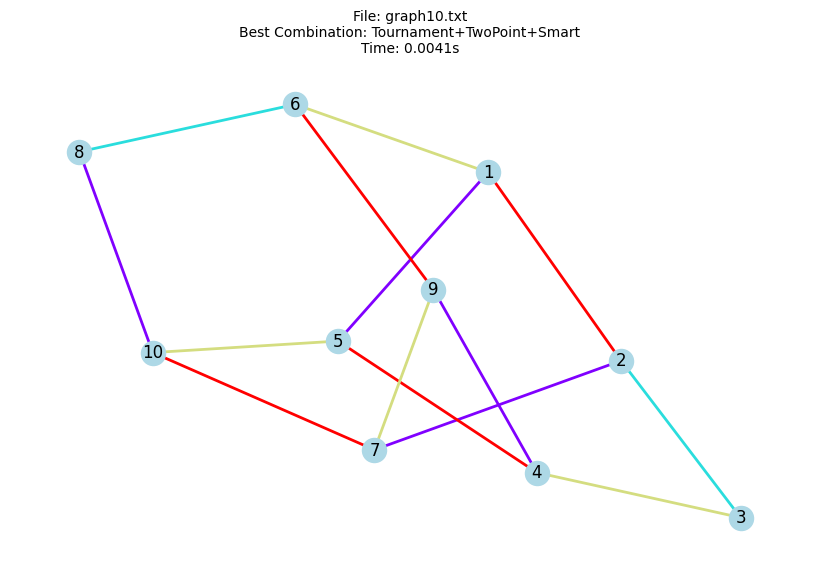


>>> Analyzing graph: graph5.txt
╒═════════════════════════════╤═════════════╤═════════╕
│ Combination                 │   Conflicts │ Time    │
╞═════════════════════════════╪═════════════╪═════════╡
│ Tournament+TwoPoint+Smart   │           0 │ 0.0005s │
├─────────────────────────────┼─────────────┼─────────┤
│ Roulette+SinglePoint+Random │           0 │ 0.0005s │
├─────────────────────────────┼─────────────┼─────────┤
│ Tournament+Uniform+Smart    │           0 │ 0.0005s │
├─────────────────────────────┼─────────────┼─────────┤
│ Tournament+TwoPoint+Swap    │           0 │ 0.0005s │
├─────────────────────────────┼─────────────┼─────────┤
│ Roulette+Uniform+Random     │           0 │ 0.0005s │
├─────────────────────────────┼─────────────┼─────────┤
│ Tournament+TwoPoint+Random  │           0 │ 0.0005s │
├─────────────────────────────┼─────────────┼─────────┤
│ Roulette+SinglePoint+Swap   │           0 │ 0.0005s │
├─────────────────────────────┼─────────────┼─────────┤
│ Roulette+Unif

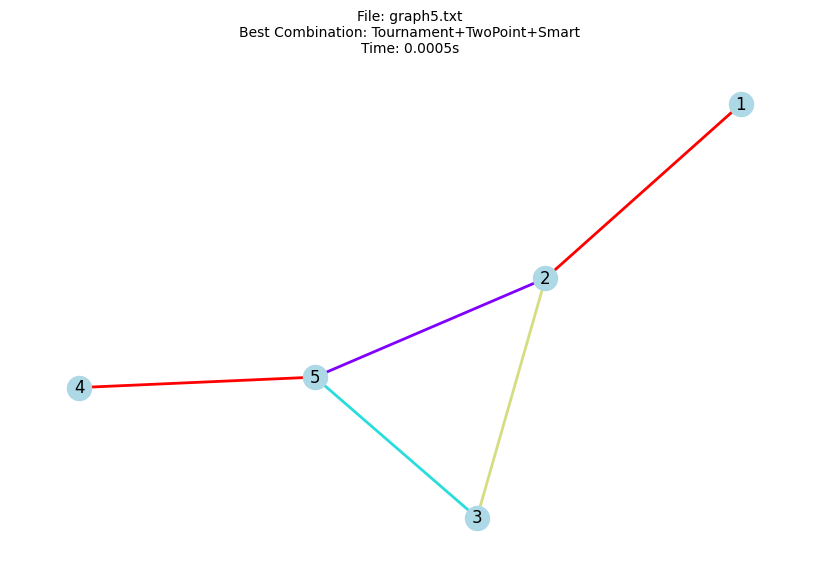


>>> Analyzing graph: graph6.txt
╒══════════════════════════════╤═════════════╤═════════╕
│ Combination                  │   Conflicts │ Time    │
╞══════════════════════════════╪═════════════╪═════════╡
│ Roulette+Uniform+Smart       │           0 │ 0.0007s │
├──────────────────────────────┼─────────────┼─────────┤
│ Rank+Uniform+Random          │           0 │ 0.0007s │
├──────────────────────────────┼─────────────┼─────────┤
│ Rank+Uniform+Smart           │           0 │ 0.0008s │
├──────────────────────────────┼─────────────┼─────────┤
│ Tournament+TwoPoint+Swap     │           0 │ 0.0008s │
├──────────────────────────────┼─────────────┼─────────┤
│ Rank+TwoPoint+Smart          │           0 │ 0.0013s │
├──────────────────────────────┼─────────────┼─────────┤
│ Tournament+SinglePoint+Smart │           0 │ 0.0016s │
├──────────────────────────────┼─────────────┼─────────┤
│ Roulette+TwoPoint+Smart      │           0 │ 0.0017s │
├──────────────────────────────┼─────────────┼─────────

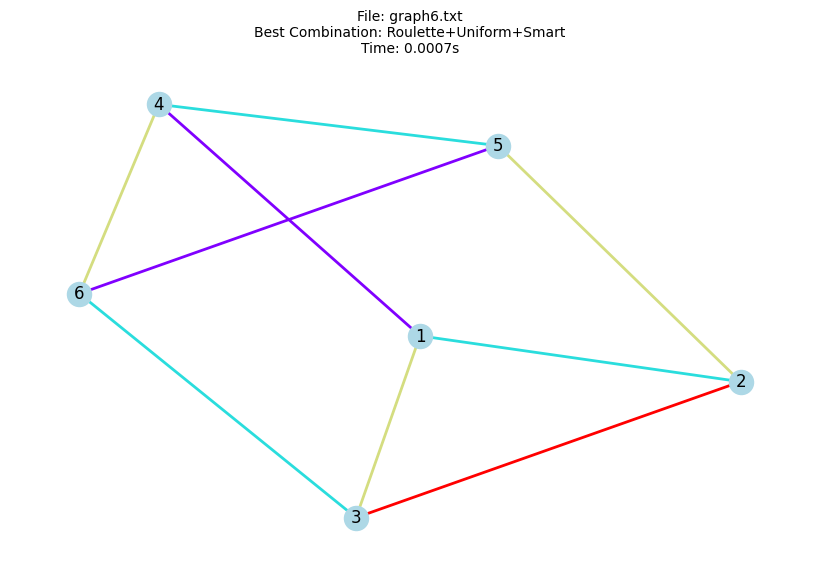


########################################
# ENTERING FOLDER: bigTests
########################################

>>> Analyzing graph: big22.txt
╒══════════════════════════════╤═════════════╤═════════╕
│ Combination                  │   Conflicts │ Time    │
╞══════════════════════════════╪═════════════╪═════════╡
│ Tournament+Uniform+Smart     │           0 │ 0.2307s │
├──────────────────────────────┼─────────────┼─────────┤
│ Tournament+TwoPoint+Smart    │           0 │ 0.3061s │
├──────────────────────────────┼─────────────┼─────────┤
│ Tournament+SinglePoint+Smart │           0 │ 0.3177s │
├──────────────────────────────┼─────────────┼─────────┤
│ Roulette+TwoPoint+Smart      │           0 │ 0.4444s │
├──────────────────────────────┼─────────────┼─────────┤
│ Rank+TwoPoint+Smart          │           0 │ 0.4717s │
├──────────────────────────────┼─────────────┼─────────┤
│ Rank+SinglePoint+Smart       │           0 │ 0.5131s │
├──────────────────────────────┼─────────────┼─────────┤
│ 

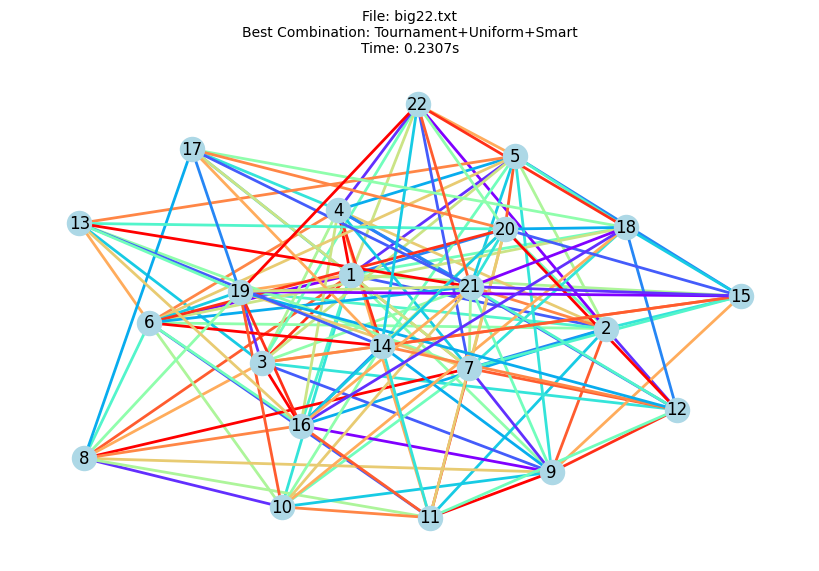


>>> Analyzing graph: big30.txt
╒══════════════════════════════╤═════════════╤═════════╕
│ Combination                  │   Conflicts │ Time    │
╞══════════════════════════════╪═════════════╪═════════╡
│ Tournament+Uniform+Smart     │           0 │ 0.7665s │
├──────────────────────────────┼─────────────┼─────────┤
│ Tournament+TwoPoint+Smart    │           0 │ 1.1852s │
├──────────────────────────────┼─────────────┼─────────┤
│ Tournament+SinglePoint+Smart │           1 │ 1.3319s │
├──────────────────────────────┼─────────────┼─────────┤
│ Rank+SinglePoint+Smart       │           1 │ 1.8443s │
├──────────────────────────────┼─────────────┼─────────┤
│ Rank+TwoPoint+Smart          │           1 │ 1.8674s │
├──────────────────────────────┼─────────────┼─────────┤
│ Rank+Uniform+Smart           │           1 │ 2.3952s │
├──────────────────────────────┼─────────────┼─────────┤
│ Roulette+TwoPoint+Smart      │           7 │ 1.2634s │
├──────────────────────────────┼─────────────┼─────────┤

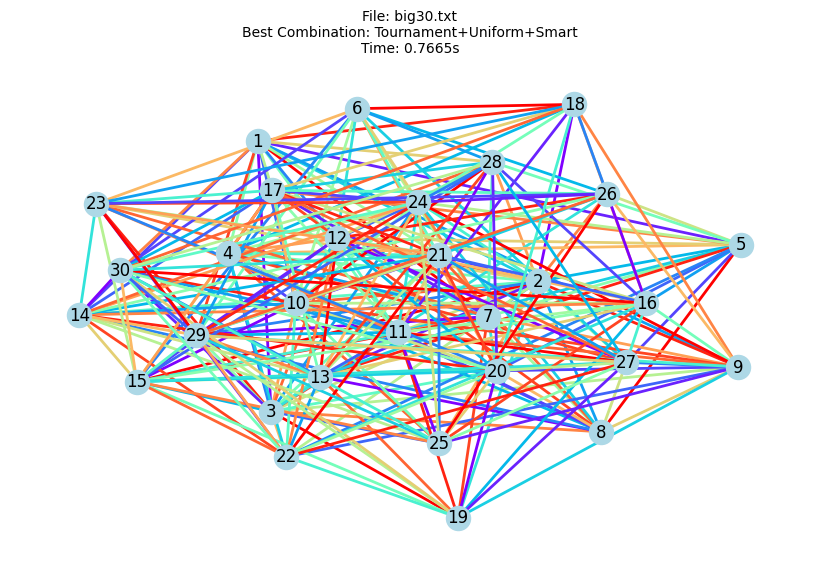


>>> Analyzing graph: big47.6.txt
╒═══════════════════════════════╤═════════════╤═════════╕
│ Combination                   │   Conflicts │ Time    │
╞═══════════════════════════════╪═════════════╪═════════╡
│ Tournament+TwoPoint+Smart     │           0 │ 0.3385s │
├───────────────────────────────┼─────────────┼─────────┤
│ Tournament+SinglePoint+Smart  │           0 │ 0.3492s │
├───────────────────────────────┼─────────────┼─────────┤
│ Tournament+Uniform+Smart      │           0 │ 0.4428s │
├───────────────────────────────┼─────────────┼─────────┤
│ Rank+TwoPoint+Smart           │           0 │ 0.7342s │
├───────────────────────────────┼─────────────┼─────────┤
│ Rank+Uniform+Smart            │           0 │ 0.7497s │
├───────────────────────────────┼─────────────┼─────────┤
│ Rank+SinglePoint+Smart        │           0 │ 0.7540s │
├───────────────────────────────┼─────────────┼─────────┤
│ Roulette+SinglePoint+Smart    │           0 │ 0.7767s │
├───────────────────────────────┼─────

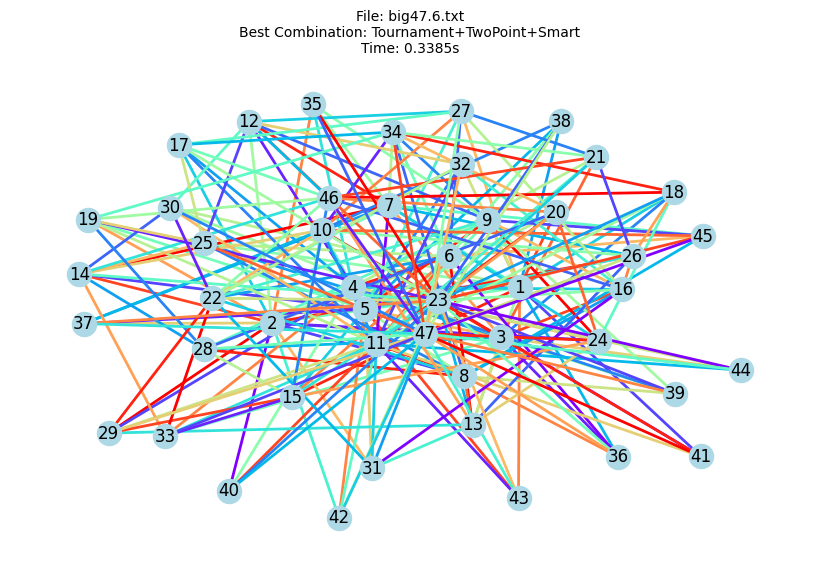


>>> Analyzing graph: big95.txt
╒══════════════════════════════╤═════════════╤═════════╕
│ Combination                  │   Conflicts │ Time    │
╞══════════════════════════════╪═════════════╪═════════╡
│ Tournament+Uniform+Smart     │           0 │ 3.4226s │
├──────────────────────────────┼─────────────┼─────────┤
│ Rank+Uniform+Smart           │           0 │ 5.3028s │
├──────────────────────────────┼─────────────┼─────────┤
│ Tournament+TwoPoint+Smart    │           2 │ 3.4422s │
├──────────────────────────────┼─────────────┼─────────┤
│ Tournament+SinglePoint+Smart │           3 │ 3.4124s │
├──────────────────────────────┼─────────────┼─────────┤
│ Rank+SinglePoint+Smart       │           6 │ 4.1139s │
├──────────────────────────────┼─────────────┼─────────┤
│ Rank+TwoPoint+Smart          │           7 │ 4.0764s │
├──────────────────────────────┼─────────────┼─────────┤
│ Tournament+Uniform+Swap      │          12 │ 4.1453s │
├──────────────────────────────┼─────────────┼─────────┤

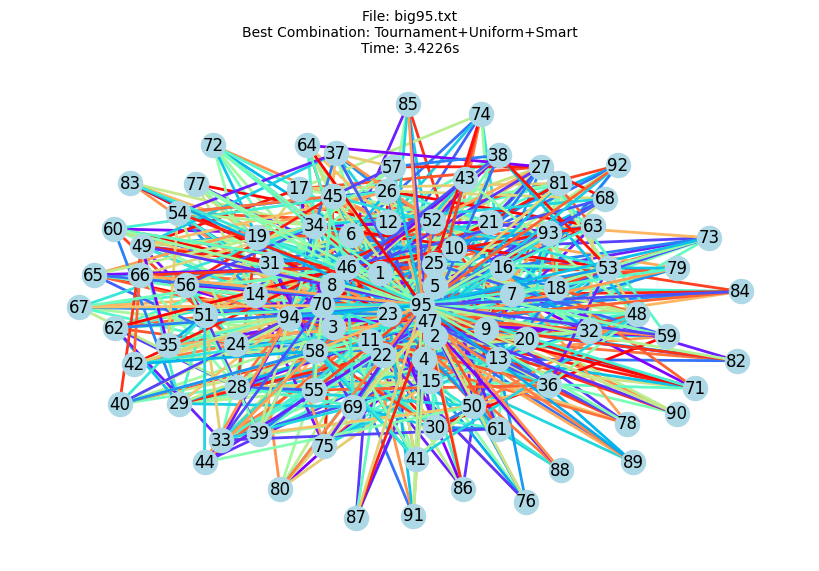

In [45]:
#Novo ucitavanje fajla

targetFolders = ['smallTests','bigTests']

for folder in targetFolders:
    #kreiramo putanju za pretragu
    searchPath = os.path.join('tests',folder,"*.txt")
    allFiles = sorted(glob.glob(searchPath))

    if not allFiles:
        print(f"No files found in: tests/{folder}")
        continue

    print(f"\n{'#'*40}\n# ENTERING FOLDER: {folder}\n{'#'*40}")

    for f in allFiles:
        #fileName = os.path.basename(f)
        processAndVisualize(f)